# **Support Vector Magic**

> *Let us bring you into the magical field of Machine Learning and Mathematical 
Optimization.*
>
> *Throughout this wonderful Notebook, you will understand how to build your very own logistic classifier from scratch, starting from the implementation of the gradient descent to the development of a Support Vector Machine.*

### **Step Zero: The Tools**

Before the start of this journey, we will need to bring with us some essential tools.

Those are the libraries and their very useful methods that we will exploit during our experiment.

Do not forget to set the random seed, as we want our experiment to be replicable by everyone.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import random, normal, seed
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

seed(0)

### **Step One: The Gradient Descent**

The gradient descent is the most famous technique in Machine Learning being an iterative method to compute the minimum of a function.

It is very easy to build a basic gradient descent, we just need:
- the gradient of the function we want to minimize
- an initial guess from which we will start to iterate
- some hyperparameters such as:
  - the learning rate
  - the number of iterations
  - a certain tolerance that will make us satisfied with our result

In [0]:
def gradient_descent(gradient, guess, learning_rate = 1e-2, iterations = 1e6, tolerance = 1e-10):
  iterations = int(iterations)
  for iteration in range(iterations):
    previous = guess
    guess = guess - learning_rate * gradient(guess)
    if norm(guess - previous) < tolerance:
      print("INFO: method converged after {} iterations".format(iteration))
      return guess
  print("ERROR: method did not converge using {} iterations and a tolerance of {}".format(iterations, tolerance))
  return guess

Let us now consider the function:
$$f(x) = x^2 - 2x + 1$$

we know its minimum to be:
$$min_f: (1, 0)$$

and its derivative to be:
$$g(x) = 2x - 2$$

our gradient descent should give us something similar.

In [0]:
f = lambda x: x**2 - 2*x + 1
g = lambda x: 2*x - 2
x_min = gradient_descent(gradient = g, guess = 0)
print('Mininum: ({},{})'.format(x_min, f(x_min)))

INFO: method converged after 947 iterations
Mininum: (0.999999995188065,0.0)


### **Step Two: The Learning Rate**

Let us do a simple experiment: using an animation, we want to understand if there is a valid learning rate for each function and its respective gradient.

In [0]:
rc('animation', html='html5')

def learning_rate_animation(title, function, gradient, learning_rate, xlim, ylim, frames = 20):
  fig, ax = plt.subplots()

  x = np.linspace(xlim[0], xlim[1], 1000)
  plt.plot(x, function(x))
  plt.title(title)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  line, = ax.plot([], [], lw=3)

  xs = [0]
  ys = [function(0)]

  def init():
      line.set_data([], [])
      return (line,)

  def animate(i):
    x = xs[i] - learning_rate * gradient(xs[i])
    y = function(x)
    xs.append(x)
    ys.append(y)
    line.set_data(xs, ys)
    return (line,)

  return animation.FuncAnimation(fig, animate, init_func = init, frames = frames, interval = 200, blit = True, repeat = False)

First of all, we try the values 0.01, 0.1 and 1.02 on our previous function.

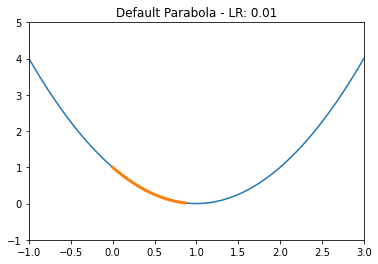

In [0]:
anim = learning_rate_animation(
  title = 'Default Parabola - LR: 0.01',
  function = lambda x: x**2 - 2*x + 1,
  gradient = lambda x: 2*x - 2,
  learning_rate = 0.01,
  xlim = (-1, 3),
  ylim = (-1, 5),
  frames = 100
)
anim

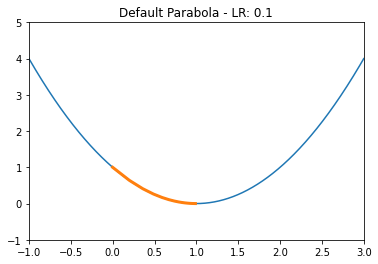

In [0]:
anim = learning_rate_animation(
  title = 'Default Parabola - LR: 0.1',
  function = lambda x: x**2 - 2*x + 1,
  gradient = lambda x: 2*x - 2,
  learning_rate = 0.1,
  xlim = (-1, 3),
  ylim = (-1, 5)
)
anim

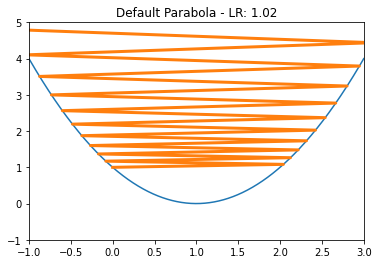

In [0]:
anim = learning_rate_animation(
  title = 'Default Parabola - LR: 1.02',
  function = lambda x: x**2 - 2*x + 1,
  gradient = lambda x: 2*x - 2,
  learning_rate = 1.02,
  xlim = (-1, 3),
  ylim = (-1, 5)
)
anim

As we can see, using a small learning rate we will need many iterations to reach the minimum, while using a big one our algorithm will not converge at all.

But, is it 0.1 the best learning rate for each function?
We should try at least another one to have any clue about this.

Let us take, for example, the strechted version of our previous parabola:
$$f(x) = 1000x^2 - 2000x + 1000$$

its minimum will also be at:
$$min_f: (1, 0)$$

and its gradient will be:
$$g(x) = 2000x - 2000$$

Now, we will try to compute its minimum using 0.1 as learning rate.

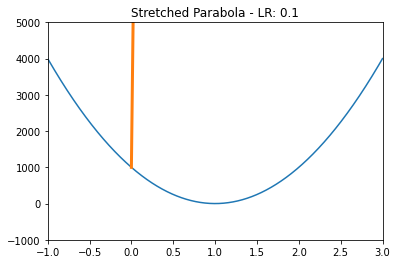

In [0]:
anim = learning_rate_animation(
  title = 'Stretched Parabola - LR: 0.1',
  function = lambda x: 1000 * (x**2 - 2*x + 1),
  gradient = lambda x: 1000 * (2*x - 2),
  learning_rate = 0.1,
  xlim = (-1, 3),
  ylim = (-1000, 5000)
)
anim

For this function, the chosen learning rate makes the algorithm diverge instantaneously.

However, considering that this is just our previous function multiplied by a constant, we can guess a better learning rate to be proportional to this constant. Indeed, a working hyperparameter would be: 0.0001!

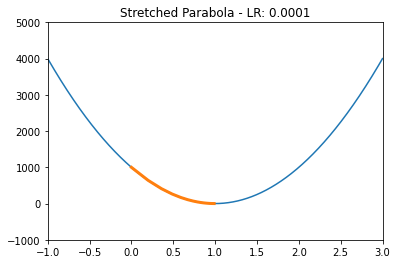

In [0]:
anim = learning_rate_animation(
  title = 'Stretched Parabola - LR: 0.0001',
  function = lambda x: 1000 * (x**2 - 2*x + 1),
  gradient = lambda x: 1000 * (2*x - 2),
  learning_rate = 0.0001,
  xlim = (-1, 3),
  ylim = (-1000, 5000)
)
anim

Nevertheless, this example shows that we should aim at implementing an adaptive version of the gradient descent.

### **Step Three: The Adaptive Gradient Descent**

We will now propose our Adaptative Gradient Descent technique, consisting in the increment or decrement of the learning rate respectively to the improvement on the result of a certain step with respect to the previous step.

In order to do this, we developed a method that computes a multiplicative factor for the learning rate based on the ratio between the variance of two consecutive guesses
$$ratio = (guess_2 - guess_1) / (guess_1 - guess_0)$$

In [0]:
def adaptive_gradient_descent(gradient, guess, learning_rate = 1e-2, alpha = 10.0, iterations = 1e6, tolerance = 1e-10):

  sqalpha = np.sqrt(alpha)
  def adaptive_factor(ratio):
    if ratio > 1:
      return alpha**-ratio + 1
    elif ratio > 0:
      return ratio / sqalpha
    else:
      return 1

  iterations = int(iterations)
  variance = 0
  for iteration in range(iterations):
    previous_variance = variance
    variance = -learning_rate * gradient(guess)
    guess = guess + variance
    if norm(variance) < tolerance:
      print("INFO: method converged after {} iterations".format(iteration))
      return guess
    learning_rate = learning_rate * adaptive_factor(norm(previous_variance / variance))
  print('ERROR: method did not converge using {} iterations and a tolerance of {}'.format(iterations, tolerance))
  return guess

Let us try now the performance of this new method when compared to the old one by comparing the number of iterations in each one of the previous cases.

In [0]:
default = lambda x: 2*x - 2
stretched = lambda x: 2000*x - 2000

for lr in [0.01, 0.1, 1.02]:
  print('Default Parabola, learning rate = {}'.format(lr))
  print('- GRADIENT DESCENT:')
  gradient_descent(default, 0, learning_rate = lr)
  print('- ADAPTIVE GRADIENT DESCENT:')
  adaptive_gradient_descent(default, 0, learning_rate = lr)
  print()

for lr in [0.1, 0.001, 0.0001]:
  print('Stretched Parabola, learning rate = {}'.format(lr))
  print('- GRADIENT DESCENT:')
  gradient_descent(stretched, 0, learning_rate = lr)
  print('- ADAPTIVE GRADIENT DESCENT:')
  adaptive_gradient_descent(stretched, 0, learning_rate = lr)
  print()

Default Parabola, learning rate = 0.01
- GRADIENT DESCENT:
INFO: method converged after 947 iterations
- ADAPTIVE GRADIENT DESCENT:
INFO: method converged after 38 iterations

Default Parabola, learning rate = 0.1
- GRADIENT DESCENT:
INFO: method converged after 96 iterations
- ADAPTIVE GRADIENT DESCENT:
INFO: method converged after 42 iterations

Default Parabola, learning rate = 1.02
- GRADIENT DESCENT:
ERROR: method did not converge using 1000000 iterations and a tolerance of 1e-10
- ADAPTIVE GRADIENT DESCENT:
INFO: method converged after 25 iterations

Stretched Parabola, learning rate = 0.1
- GRADIENT DESCENT:
ERROR: method did not converge using 1000000 iterations and a tolerance of 1e-10
- ADAPTIVE GRADIENT DESCENT:
INFO: method converged after 50 iterations

Stretched Parabola, learning rate = 0.001
- GRADIENT DESCENT:
ERROR: method did not converge using 1000000 iterations and a tolerance of 1e-10
- ADAPTIVE GRADIENT DESCENT:
INFO: method converged after 24 iterations

Stretch

As we can see, the performance is definitely better in particular for those cases in which the initial learning rate is totally unsuitable.

To present a better explanation, we also provide the following animations.

In [0]:
def adaptive_animation(title, function, gradient, learning_rate, xlim, ylim, frames = 20):
  fig, ax = plt.subplots()

  x = np.linspace(xlim[0], xlim[1], 1000)
  plt.plot(x, function(x))
  plt.title(title)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  line, = ax.plot([], [], lw=3)

  xs = [0]
  ys = [function(0)]
  vs = [0]
  ls = [learning_rate]
  
  def init():
      line.set_data([], [])
      return (line,)

  def animate(i):
    def adaptive_factor(x):
      if x > 1:
        return 100**-x + 1
      elif x > 0:
        return x / 10
      else:
        return 1
    v = -ls[i] * gradient(xs[i])
    x = xs[i] + v
    y = function(x)
    l = ls[i] * adaptive_factor(norm(vs[i] / v))
    xs.append(x)
    ys.append(y)
    vs.append(v)
    ls.append(l)
    line.set_data(xs, ys)
    return (line,)

  return animation.FuncAnimation(fig, animate, init_func = init, frames = frames, interval = 200, blit = True, repeat = False)

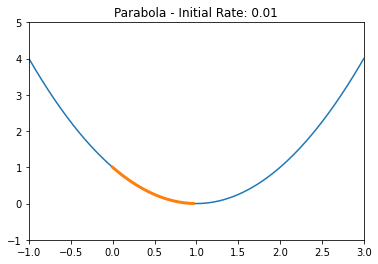

In [0]:
anim = adaptive_animation(
  title = 'Parabola - Initial Rate: 0.01',
  function = lambda x: x**2 - 2*x + 1,
  gradient = lambda x: 2*x - 2,
  learning_rate = 0.01,
  xlim = (-1, 3),
  ylim = (-1, 5),
  frames = 100
)
anim

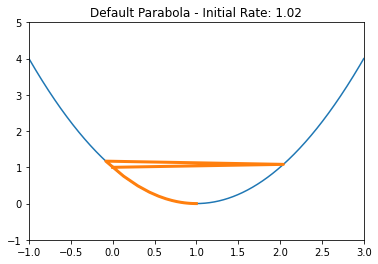

In [0]:
anim = adaptive_animation(
  title = 'Default Parabola - Initial Rate: 1.02',
  function = lambda x: x**2 - 2*x + 1,
  gradient = lambda x: 2*x - 2,
  learning_rate = 1.02,
  xlim = (-1, 3),
  ylim = (-1, 5),
  frames = 40
)
anim

Though in some cases the method should be slow or fail as well as before, it is also evident that its robustness has been increased, hence we can go straight to our next chapter!

### **Step Four: The Loss Function**

Say that we have some data that can be split into a vector (or matrix) X and, namely the independent variable, and a vector y, namely the dependent variable. Our aim is to predict future values of y given future values of X, and to do so we train our model on the data we have been provided trying to minimize the difference between our predicted values of y and the real ones.

Our model is linear, hence we have a set of parameters *θ*, each one related to one feature of the data matrix X (plus one parameter to represent the bias, so that X is actually [1|X]). We would like *θ* to be so that:

$$X \cdot θ = y$$

but, since we cannot be so optimistic, we should define a loss function that measures how much our solution is distant from the real y.

Therefore, our loss function could be written as:

$$L(θ) = (X \cdot θ - y)^2$$

and, being our purpose to minimize it, we should apply the gradient descent on it, where its gradient is:

$$G(θ) = X^T \cdot (X \cdot θ - y)$$

We are now able to perform our linear regression!

In [0]:
def linear_regression(X, y, guess = None, learning_rate = 1e-2, alpha = 10.0, iterations = 1e6, tolerance = 1e-10):
  # first of all, we make the vectors to be columns (matrices are assumed to be well-shaped)
  if X.ndim == 1:
    X = X.reshape(-1, 1)
  y = y.reshape(-1, 1)

  # then a column of ones is added to the dataset to represent the bias
  ones = np.ones(X.shape[0]).reshape(-1, 1)
  X = np.concatenate((ones, X), axis = 1)
  if guess == None:
    guess = np.zeros(X.shape[1])

  def gLoss(t):
    t = t.reshape(-1, 1)
    g = np.dot(X.transpose(), np.dot(X, t) - y)
    return g.reshape(-1,)

  # if alpha is different from none, we use the adaptive gradient descent
  if alpha == None:
    return gradient_descent(
        gLoss,
        guess,
        learning_rate = learning_rate,
        iterations = iterations,
        tolerance = tolerance
      )
  else:
    return adaptive_gradient_descent(
        gLoss,
        guess,
        learning_rate = learning_rate,
        alpha = alpha,
        iterations = iterations,
        tolerance = tolerance
      )

Let us try now a little experiment.

First of all, we randomly take two values *a* and *b* into the interval [-5, 5]. We do not actually know their values, but we use them to create two series of samples from the linear function:

$$y = ax + b$$

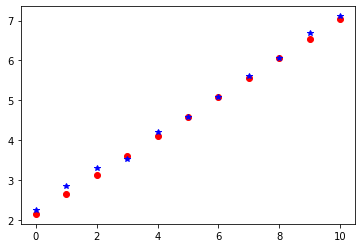

In [0]:
n = 5
a = 2 * n * random() - n
b = 2 * n * random() - n
x = np.linspace(0, 10, 11)
y_pure = a * x + b
y_noise = np.array([a * v + b + normal(0, abs(a/n)) for v in x])
plt.plot(x, y_pure, 'ro', x, y_noise, 'b*')
plt.show()

As we can see, the two series of samples are not completely overlapped as in the second one - the blue one - we have introduced a little gaussian noise with a variance proportional to *a*.

In any case, performing a linear regression on both our dataset, we are now able to predict those values *a* and *b*.

In [0]:
t_pure = linear_regression(x, y_pure)
t_noise = linear_regression(x, y_noise)
print('         ACTUAL: a = {}, b = {}'.format(a, b))
print(' PREDICTED PURE: a = {}, b = {}'.format(t_pure[1], t_pure[0]))
print('PREDICTED NOISE: a = {}, b = {}'.format(t_noise[1], t_noise[0]))

INFO: method converged after 1020 iterations
INFO: method converged after 1051 iterations
         ACTUAL: a = 0.48813503927324753, b = 2.151893663724195
 PREDICTED PURE: a = 0.48813504031206467, b = 2.1518936565119375
PREDICTED NOISE: a = 0.48131616854958376, b = 2.253220868386753


As we can see, the predicted values are very close to the real ones.

In particular, without noise we are practically able to retrieve the original parameters of the linear function, while on the perturbed dataset the results are less precise but still impressive.

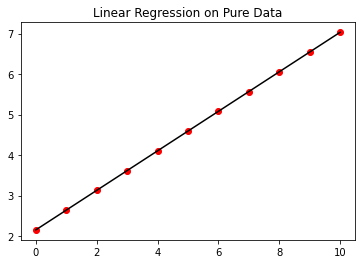

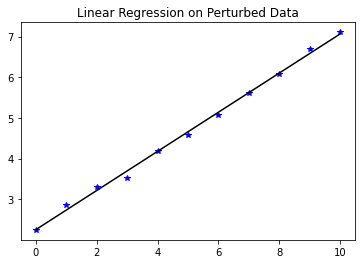

In [0]:
plt.plot(x, y_pure, 'ro', x, t_pure[0] + t_pure[1] * x, 'k')
plt.title('Linear Regression on Pure Data')
plt.show()

plt.plot(x, y_noise, 'b*', x, t_noise[0] + t_noise[1] * x, 'k')
plt.title('Linear Regression on Perturbed Data')
plt.show()

For a better understanding of the way linear regression work, we will eventually propose this step-by-step animation.

In [0]:
def linear_regression_animation(X, y, gradient):
  fig, ax = plt.subplots()

  plt.plot(x, y_pure, 'ro')

  ax.set_xlim((0, 10))
  ax.set_ylim((min(y_pure), max(y_pure)))
  line, = ax.plot([], [], lw=3)

  ts = [np.array([[0], [0]])]

  def init():
      line.set_data([], [])
      return (line,)

  def animate(i):
    t = ts[i] - 0.004 * gradient(ts[i])
    ts.append(t)
    line.set_data(x, t[0] + t[1] * x)
    return (line,)

  return animation.FuncAnimation(fig, animate, init_func = init, frames = 300, interval = 10, blit = True, repeat = False)

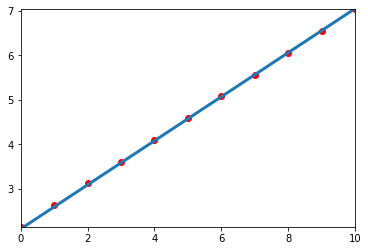

In [0]:
X = np.concatenate((np.ones(11).reshape(-1, 1), x.reshape(-1, 1)), axis = 1)
Y = y_pure.reshape(-1, 1)
anim = linear_regression_animation(X, Y, lambda t: np.dot(X.transpose(), np.dot(X, t) - Y))
anim

### **Step Five: The Hinge Regression with Regularization**

Let us say that we have a set of samples which is divided into two classes: some samples are positive and some other are negative.
Well, there must be a rule to understand which one is of a certain kind, and we aim to understand that rule!

Here, we have just created a dataset of points split into two different classes. Moreover, we added some salt-and-pepper noise to simulate the presence of outliers.

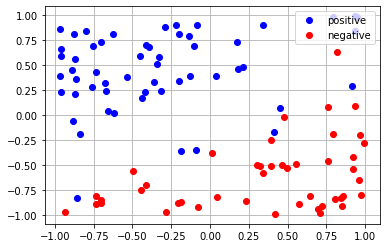

In [0]:
def generate_data(n, hyperplane, dimensions = 2, threshold_factor = 1.0, outlier_factor = 0.5):
  X = []
  y = []
  while len(X) < n:
    x = 2 * random(dimensions) - 1
    c = hyperplane(x)
    if threshold_factor * random() < abs(c):
      X.append(list(x))
      y.append((outlier_factor * random() > abs(c)) ^ (c < 0))
  return (np.array(X), np.array(y))

def separation_line(x):
  return x / 2

X, y = generate_data(100, lambda x: separation_line(x[0]) - x[1])
x0 = X[:, 0]
x1 = X[:, 1]

plt.plot(x0[y == True], x1[y == True], 'bo', label = 'positive')
plt.plot(x0[y == False], x1[y == False], 'ro', label = 'negative')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

The Hinge Regression is very similar to a Linear Regression. In fact, the only thing that changes between them is the loss function, which is built specifically to deal with a binary output that can be either -1 or +1.

Once taken again our dataset *X*, our classes *y* - the ones to be predicted - and our vector of parameters *θ*, while before we were hypothesizing a linear representation of them, namely:

$$h(x) = X \cdot θ$$

where *h(x)* is the so-called **hypothesis**, we now apply an activation function to fit a new hypothesis, namely:

$$h(x) = 
\begin{cases}
  1 & if \ \ X \cdot θ ≥ 0 \\
  -1 & otherwise
\end{cases}$$

Once we have our hypothesis, we can define a new loss function based on its logarithm. Whenever the actual class is matched - namely *y = 1* and we predict a one - the cost should be almost zero while, on the other case, it should be heading towards infinity so that:

$$pred / real$$ | $$y = -1$$ | $$y = 1$$
--- | --- | ---
$$h(x) = -1$$ | $$0$$ | $$+∞$$
$$h(x) = 1$$ | $$+∞$$ | $$0$$

Therefore, for a single sample, the loss will be:

$$L_i(X_i, y_i, θ) = max(0, 1 - y_i X_i \cdot θ) = λ_i (1 - y_i X_i \cdot θ), \ \ where \ \ λ_i = 
\begin{cases}
  1 & if \ \ y_i X_i \cdot θ < 1 \\
  0 & if \ \ otherwise
\end{cases}$$

its gradient being:

$$G_i(X_i, y_i, θ) = -λ_i y_i X_i =
\begin{cases}
  - y_i X_i & if \ \ y_i X_i \cdot θ < 1 \\
  0 & otherwise
\end{cases}$$

Notice that the hinge loss is so that, for those samples having *abs(xθ) ≥ 1* the loss is zero if and only if *h(xθ) = y*, namely their prediciton was correct, while for those having *-1 < xθ < 1* or labelled with a wrong prediction the loss is proportional to the data itself. Those last samples are called **support vectors** as they are those vectors for which it is difficult to find a decision boundary, and they are also the only ones that matters when computing the loss function which, for the total samples, will be:

$$L(θ) = \sum_i λ_i (1 - y_i X_i \cdot θ) = \sum_i max(0, 1 - y_i X_i \cdot θ)$$

its gradient being:

$$G(θ) = \sum_i λ_i y_i X_i = \sum_i G_i(X_i, y_i, θ)$$

Finally, in order not to give so much weight to outliers, we can add a regularization parameter *C* to our loss function making it:

$$L_{reg}(θ) = C * L(θ) + \frac{1}{2} \sum_i θ_i^2$$

its gradient being:

$$G_{reg}(θ) = C * G(θ) + θ$$

where the regularization is inversly proportional to the factor *C*.


In [0]:
def hinge_regression(X, y, guess = None, learning_rate = 1e-2, alpha = 10.0, C = 1.0, iterations = 1e6, tolerance = 1e-10):
  # first of all, we map the y values into -1 and 1
  d = np.unique(y)
  d = { d[0]: -1, d[1]: 1 }
  y = np.array([d[v] for v in y])

  if X.ndim == 1:
    X = X.reshape(-1, 1)
  y = y.reshape(-1, 1)

  ones = np.ones(X.shape[0]).reshape(-1, 1)
  X = np.concatenate((ones, X), axis = 1)
  if guess == None:
    guess = np.zeros(X.shape[1])

  if C == None:
    def gLoss(t):
      z = np.zeros(X.shape[1])
      t = t.reshape(-1, 1)
      return np.sum([-v if np.dot(v, t) < 1 else z for v in X * y], axis = 0)
  else:
    def gLoss(t):
      z = np.zeros(X.shape[1])
      t = t.reshape(-1, 1)
      g = np.sum([-v if np.dot(v, t) < 1 else z for v in X * y], axis = 0)
      return C * g + t.reshape(-1,)

  # if alpha is different from none, we use the adaptive gradient descent
  if alpha == None:
    return gradient_descent(
        gLoss,
        guess,
        learning_rate = learning_rate,
        iterations = iterations,
        tolerance = tolerance
      )
  else:
    return adaptive_gradient_descent(
        gLoss,
        guess,
        learning_rate = learning_rate,
        alpha = alpha,
        iterations = iterations,
        tolerance = tolerance
      )

INFO: method converged after 3223 iterations


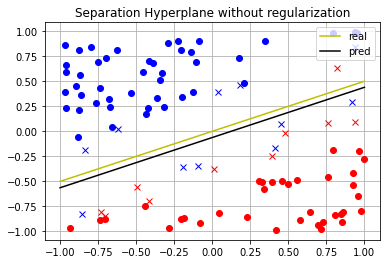

In [0]:
c, a, b = hinge_regression(X, y)
support = np.array([abs(a * xi0 + b * xi1 + c) < 1 for (xi0, xi1) in zip(x0, x1)])

x = np.linspace(-1, 1, 100)
plt.plot(x0[np.logical_and(y == True, support == False)], x1[np.logical_and(y == True, support == False)], 'bo')
plt.plot(x0[np.logical_and(y == True, support == True)], x1[np.logical_and(y == True, support == True)], 'bx')
plt.plot(x0[np.logical_and(y == False, support == False)], x1[np.logical_and(y == False, support == False)], 'ro')
plt.plot(x0[np.logical_and(y == False, support == True)], x1[np.logical_and(y == False, support == True)], 'rx')
plt.plot(x, separation_line(x), 'y', label = 'real')
plt.plot(x, -(a * x + c) / b, 'k', label = 'pred')
plt.title('Separation Hyperplane without regularization')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

As we can see, the separation hyperplane is really close to the real one, and the two classes are quite well separated. Also, those marked on the plot with a cross instead of a point are the support vectors.

### **Final Step: The Classifier**

Once at this point, there is just one more thing to do: merge everything into a single python class, which will represent our very magical classifier! 

In [0]:
class SVC:
  #
  # learning_rate: the learning rate of the descent
  #         alpha: the adaptive gradient hyperparameter (if 'None', no adaptive method is used)
  #             C: the regulation factor (if 'None', no regularization is applied)
  #    iterations: the maximum number of iterations 
  #     tolerance: the tolerance to reach
  #
  def __init__(
      self,
      learning_rate = 1e-2, 
      alpha = 10.0, 
      C = 1.0, 
      iterations = 1e6, 
      tolerance = 1e-10,
      info = False
  ):
    #
    # adaptive function
    #
    if alpha == None:
      def af(ratio): return 1
    else:
      sqalpha = np.sqrt(alpha)
      def af(ratio):
        if ratio > 1:
          return alpha**-ratio + 1
        elif ratio > 0:
          return ratio / sqalpha
        else:
          return 1
    #
    # gradient function
    #
    if C == None:
      def hg(X, y, t):
        t = t.reshape(-1, 1)
        return np.sum([-v if np.dot(v, t) < 1 else np.zeros(X.shape[1]) for v in X * y], axis = 0)
    else:
      def hg(X, y, t):
        t = t.reshape(-1, 1)
        g = np.sum([-v if np.dot(v, t) < 1 else np.zeros(X.shape[1]) for v in X * y], axis = 0)
        return C * g + t.reshape(-1,)
    #
    # parameters
    #
    self.adaptive_factor = lambda r: af(r)
    self.gradient = lambda X, y, t: hg(X, y, t)
    self.learning_rate = learning_rate
    self.iterations = int(iterations)
    self.tolerance = tolerance,
    self.info = False

  #
  #     X: the features dataset
  #     y: the classes vector
  # guess: the initial guess (if 'None', a vector of zeros is used)
  #
  def fit(self, X, y, guess = None):
    X_unmodified = X
    y_unmodified = y
    #
    # data preprocessing
    #
    self.classes_ = np.unique(y)
    y = np.array([-1 if c == self.classes_[0] else 1 for c in y]).reshape(-1, 1)
    if X.ndim == 1:
      X = X.reshape(-1, 1)
    ones = np.ones(X.shape[0]).reshape(-1, 1)
    X = np.concatenate((ones, X), axis = 1)
    #
    # actual gradient descent
    #
    variance = 0
    current_rate = self.learning_rate
    theta = np.zeros(X.shape[1]) if guess == None else guess
    for iteration in range(self.iterations):
      previous_variance = variance
      variance = -current_rate * self.gradient(X, y, theta)
      theta = theta + variance
      if norm(variance) < self.tolerance: break
      current_rate = current_rate * self.adaptive_factor(norm(previous_variance) / norm(variance))
    #
    # set parameters
    #
    self.coef_ = theta[1:]
    self.intercept_ = theta[0]
    self.labels_ = self.label(X_unmodified, y_unmodified)
    self.evaluations_ = self.evaluate(X_unmodified, y_unmodified)
    self.support_vectors_ = np.array([abs(np.dot(x, theta)) < 1 for x in X])
    return self

  #
  # X: the features
  #
  # > returns an array of predictions
  #
  def predict(self, X):
    v = np.dot(X, self.coef_) + self.intercept_
    return np.array([self.classes_[0] if p < 0 else self.classes_[1] for p in v])

  #
  # X: the features
  # y: the classes
  #
  # > returns an array of labels of kind True/False - Positive/Negative
  #
  def label(self, X, y):
    p = self.predict(X)
    d = { (True, True): 'TP', (False, False): 'TN', (True, False): 'FN', (False, True): 'FP' }
    return np.array([d[(yy, pp)] for (yy, pp) in zip(y, p)])
    
  #
  # X: the features
  # y: the classes
  #
  # > returns a dictionary of the main measures for a binary classifier
  #
  def evaluate(self, X, y):
    results = self.label(X, y)
    TP = len(results[results == 'TP'])
    TN = len(results[results == 'TN'])
    FN = len(results[results == 'FN'])
    FP = len(results[results == 'FP'])
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return { 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1 }

And here it is!

Let us underline that the measures (*accuracy*, *precision*, *recall* and *f1*) are values used to evaluate the performances of a classification model: the higher the values, the better the classification. Therefore, it is now time to evaluate our classification model!

In [0]:
hyperplane = lambda x: x[0] / 2 - x[1]
X_train, y_train = generate_data(1000, hyperplane)
X_test, y_test = generate_data(300, hyperplane)

svc = SVC().fit(X_train, y_train)

training_evaluation = svc.evaluations_
print('EVALUATION OF THE TRAINING SET:')
print('>   Accuracy: {}%'.format(round(100 * training_evaluation['accuracy'])))
print('>  Precision: {}%'.format(round(100 * training_evaluation['precision'])))
print('>     Recall: {}%'.format(round(100 * training_evaluation['recall'])))
print('> F1 Measure: {}%'.format(round((100 * training_evaluation['f1']))))
print()

test_evaluation = svc.evaluate(X_test, y_test)
print('EVALUATION OF THE TEST SET:')
print('>   Accuracy: {}%'.format(round(100 * test_evaluation['accuracy'])))
print('>  Precision: {}%'.format(round(100 * test_evaluation['precision'])))
print('>     Recall: {}%'.format(round(100 * test_evaluation['recall'])))
print('> F1 Measure: {}%'.format(round((100 * test_evaluation['f1']))))

EVALUATION OF THE TRAINING SET:
>   Accuracy: 92%
>  Precision: 92%
>     Recall: 91%
> F1 Measure: 92%

EVALUATION OF THE TEST SET:
>   Accuracy: 94%
>  Precision: 97%
>     Recall: 91%
> F1 Measure: 94%


Our classification model is doing very well!

And, finally, we can now plot the results obtained on our test set. 

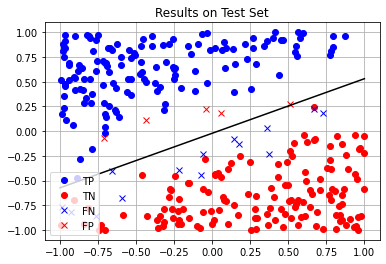

In [0]:
r = svc.label(X_test, y_test)
c = svc.intercept_
a, b = svc.coef_

x = np.linspace(-1, 1, 10)
x0 = X_test[:, 0]
x1 = X_test[:, 1]
plt.plot(x0[r == 'TP'], x1[r == 'TP'], 'bo', label = 'TP')
plt.plot(x0[r == 'TN'], x1[r == 'TN'], 'ro', label = 'TN')
plt.plot(x0[r == 'FN'], x1[r == 'FN'], 'bx', label = 'FN')
plt.plot(x0[r == 'FP'], x1[r == 'FP'], 'rx', label = 'FP')
plt.plot(x, -(a * x + c) / b, 'k')
plt.title('Results on Test Set')
plt.legend(loc = 'lower left')
plt.grid()
plt.show()